In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import h5py
import pandas as pd
import numpy as np
import copy
import os
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [36]:
# daa = load_data('2018092_20180930')
# format1_path = 'data_format1_' + '20181007_20181014' + '.h5'
# f1_data = pd.HDFStore(os.path.join(data_root, format1_path))


Python 3.7.0


In [15]:
data_root = '../../data/'
root = './'
model_folder = './models/'
report_folder = './report_rc/'

In [4]:
'''
format1: {currency_type: {time: ['close', 'high', 'low', 'open', 'volume']}}
format2: {time: {currency_type: ['close', 'high', 'low', 'open', 'volume']}}
'''

def load_data(date_list):
    data_root = '../../data/'
    currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
    curr_info = dict.fromkeys(currencies)
    
    date_list = date_list if type(date_list) is list else [date_list]
    
    for date in date_list:
        print(f'load data from {date}')
        format1_path = 'data_format1_' + date + '.h5'
        f1_data = pd.HDFStore(os.path.join(data_root, format1_path))

        for curr in currencies:
            if curr_info[curr] is None:
                curr_info[curr] = f1_data[curr]
            else:
                curr_info[curr] = curr_info[curr].append(f1_data[curr])
        f1_data.close()
        
    for key, item in curr_info.items():
        curr_info[key]['volume_minmax'] = MinMaxScaler().fit_transform(item[['volume']]).reshape(1,-1)[0]        
        curr_info[key]['avg'] = item[['close', 'high', 'low', 'open']].mean(axis=1)
        
    return curr_info # {curr_name: cur_df}

def load_h5(date):
    data_root = './drive/Colab Notebooks/data/'
    format1_path = 'data_format1_' + date + '.h5'
    format2_path = 'data_format2_' + date + '.h5'
    
    f1_data = h5py.File(os.path.join(data_root, format1_path), 'r')
    f2_data = h5py.File(os.path.join(data_root, format2_path), 'r')
    
    return f1_data, f2_data
    

In [6]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
data['BCH-USD'].head()

,close,high,low,open,volume,volume_minmax,avg
time,,,,,,,
2018-09-01 06:00:00,550.97,550.97,550.97,550.97,1.839054,0.000979,550.970
2018-09-01 06:01:00,550.97,550.97,550.97,550.97,0.000000,0.000000,550.970
2018-09-01 06:02:00,550.97,550.97,550.97,550.97,0.000000,0.000000,550.970
2018-09-01 06:03:00,550.96,550.97,550.96,550.97,0.086600,0.000046,550.965
2018-09-01 06:04:00,550.97,550.97,550.96,550.96,7.050036,0.003754,550.965


In [31]:
date_list = ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808',
             '20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
             '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
             '20181028_20181104', '20181104_20181111']
# date_list = ['20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
#              '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
#              '20181028_20181104', '20181104_20181111']

data = load_data(date_list)

load data from 201801
load data from 201802
load data from 201803
load data from 201804
load data from 201805
load data from 201806
load data from 201807
load data from 201808
load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111


In [32]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

for curr in currencies:
    data[curr] = data[curr].reset_index()
    data[curr] = data[curr].drop_duplicates(subset='time', keep='first')
    data[curr] = data[curr].set_index('time')

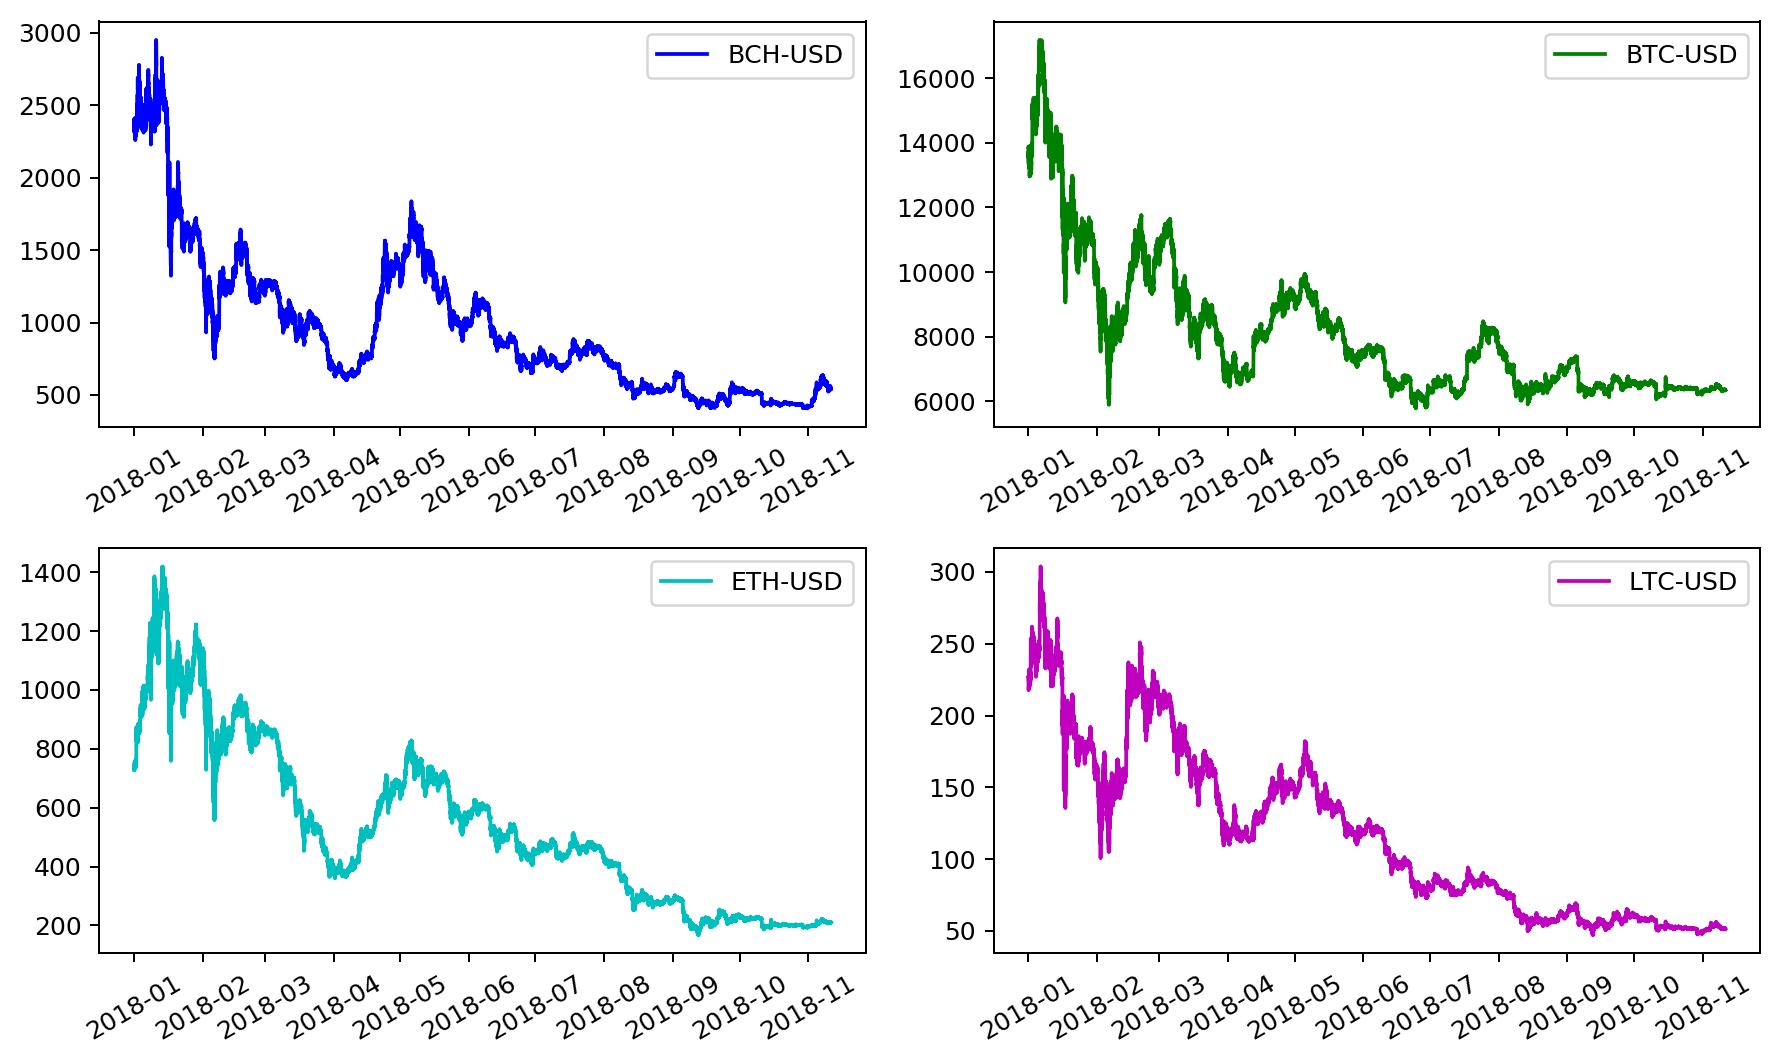

In [33]:
plt.figure(figsize=(10, 6), dpi=180)
colors = ['b', 'g', 'c', 'm']
for i in range(4):
    curr = currencies[i]
    color = colors[i]
    plt.subplot(2,2,i+1)
    plt.plot(data[curr].index, data[curr][['avg']], color, label=curr)
    plt.axis('tight')
    plt.legend()
    plt.xticks(rotation=60)
    
plt.tight_layout()
plt.savefig(os.path.join(report_folder, 'Average_Prices_of_Currencies_1801_1812.jpg'))
plt.show()

## Modeling

In [8]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, Flatten

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


In [9]:
def build_model(dims_per_layer):
    loss_func = 'mse'
    optimiser_func = 'rmsprop'
    activation_func = 'linear'  # tanh
    
    rnn_model = Sequential()

    # Plan A
    rnn_model.add(LSTM(
                input_dim=dims_per_layer[0],
                output_dim=50,
                return_sequences=True))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(LSTM(100, return_sequences=False))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(Dense(output_dim=1))
    rnn_model.add(Activation(activation_func))
 
    rnn_model.compile(loss=loss_func, optimizer=optimiser_func)
    return rnn_model

def train_model(model_name, train_x, train_y, epoches=100, batch_size=4):
    
    model = build_model([train_x.shape[-1], 128, 64, 1])
    history = model.fit(train_x, train_y, epochs=epoches, batch_size=batch_size, verbose=2)

    model.save(os.path.join(model_folder, f'./{model_name}.h5'))
    return model, history
    

def split_train_xy(df, window_x, window_y, stride=1):
    train_x = []
    train_y = []
    i = 0
    while(i+window_x+window_y < len(df)):
        train_x = train_x.append((df[i:(i+window_x)][['open', 'close', 'high', 'low', 'volume_minmax']]).values)
#         train_y.append(df[(i+window_x):(i+window_x+window_y)][['avg']])
        train_y = train_y.append((df.iloc[(i+window_x+window_y)][['avg']]).values)
        
        i += stride
                
    return train_x, train_y


In [10]:
# build model & prepare train test data set
def create_dataset(dataset, look_back=1, look_forward=1):
    data_x = []
    data_y = [] # value changed of next look_forward duration
    i = 0
    while i < len(dataset)-look_back-look_forward-1:
        x = dataset[i:(i+look_back), 0]
        data_x.append(x)
        y = dataset[i+look_back+look_forward, 0] - dataset[i+look_back, 0]
        data_y.append(y)
        i += look_forward
        
    return np.array(data_x), np.array(data_y)

In [35]:

# data_ltc = data['LTC-USD'][['avg']]
# train_size = int(len(data_ltc) * 0.8)
# train_ltc, test_ltc = data_ltc.values[0:train_size, :], data_ltc.values[train_size:len(data_ltc), :]

# look_back = 60 * 2
# look_forward = 60
# train_ltc_x, train_ltc_y = create_dataset(train_ltc, look_back)
# test_ltc_x, test_ltc_y = create_dataset(test_ltc, look_back)
# # minmaxscaler precessing

In [0]:
# train_ltc_x = np.reshape(train_ltc_x, (train_ltc_x.shape[0], 1, train_ltc_x.shape[1]))
# test_ltc_x = np.reshape(test_ltc_x, (test_ltc_x.shape[0], 1, test_ltc_x.shape[1]))

# # ltc_model = train_model('ltc_model', x_train, y_train)

In [0]:
# train_ltc_x.shape

(35710, 1, 1)

In [0]:
# model_ltc = train_model('model_ltc', train_ltc_x, train_ltc_y)

In [0]:
# train_ltc_predict = model_ltc.predict(train_ltc_x)
# test_ltc_predict = model_ltc.predict(test_ltc_x)

In [25]:
## Increasing Window size

# date_list = ['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808',
#              '20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
#              '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
#              '20181028_20181104', '20181104_20181111']
date_list = ['20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930',
             '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028',
             '20181028_20181104', '20181104_20181111']

data = load_data(date_list)

load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111
load data from 20181111_20181118


In [34]:
time_unit = 60
look_back = time_unit * 2
look_forward = time_unit * 1

models = {}
history = {}

for curr in currencies:
    print(f'{curr} data processing')
    data_curr = data[curr][['avg']]
    train_x, train_y = create_dataset(data_curr.values, look_back, look_forward)
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    print(train_x.shape)
    
    print(f'{curr} model training')
    model_curr, history = train_model(f'{curr}_model_1809_1811', train_x, train_y)
    models[curr] = model_curr
    history[curr] = history

load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111


In [26]:
li = []
for i in currencies:
    li.append(joblib.load(os.path.join(root, f'model_{curr.lower()}.joblib')))

FileNotFoundError: [Errno 2] No such file or directory: './model_bch-usd.joblib'

In [27]:
i = 0
for m in li:
    m.save(os.path.join(root, f'model_{currencies[i].lower()}.h5'))
    i+=1

In [11]:
m = build_model([120])
m.load_weights(os.path.join(model_folder, 'model_bch_weight.h5'))

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [17]:
import keras
print(keras.__version__)

2.2.4
